<a href="https://www.kaggle.com/code/sharanharsoor/nmt-seq2seq-eng-2-hindi?scriptVersionId=122670188" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction. 
Came across 2 amazing works on sequence-to-sequence and sequence-to-sequence with attention. These notebooks explain the neural machine translation models. For learning, in this notebook combine both notebooks and put a few details for better understanding. 
1. NMT Seq2Seq Indian Languages :  https://www.kaggle.com/code/uplytics/nmt-seq2seq-indian-languages
2. NMT Seq2Seq Indian Languages with Attention : https://www.kaggle.com/code/uplytics/nmt-seq2seq-indian-languages-with-attention

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import unicodedata
import numpy as np
import re
import os 
import io
import time
import matplotlib.pyplot as plt
!pip3 install indic-nlp-library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 13.2 MB/s eta 0:00:00


In [2]:
!wget "http://lotus.kuee.kyoto-u.ac.jp/WAT/indic-multilingual/indic_languages_corpus.tar.gz"

--2023-03-19 14:46:01--  http://lotus.kuee.kyoto-u.ac.jp/WAT/indic-multilingual/indic_languages_corpus.tar.gz
Resolving lotus.kuee.kyoto-u.ac.jp (lotus.kuee.kyoto-u.ac.jp)... 130.54.208.131
Connecting to lotus.kuee.kyoto-u.ac.jp (lotus.kuee.kyoto-u.ac.jp)|130.54.208.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132762852 (127M) [application/x-gzip]
Saving to: ‘indic_languages_corpus.tar.gz’

indic_languages_cor 100%[===================>] 126.61M  29.8MB/s    in 4.9s    

2023-03-19 14:46:07 (26.0 MB/s) - ‘indic_languages_corpus.tar.gz’ saved [132762852/132762852]



In [3]:
import tarfile
with tarfile.open('indic_languages_corpus.tar.gz', 'r:gz') as tar:
    tar.extractall()
print("done!")

done!


In [4]:
#We copy the Hindi to English files for working in this example (dev.en, dev.hi, test.en, test.hi and train.en, train.hi)
%cp indic_languages_corpus/bilingual/hi-en/* .
#Clean up to avoid storing these files in the session
%rm -r indic_languages_corpus indic_languages_corpus.tar.gz

In [5]:
# Install Nirmala font which we would need for plotting later in the code
!wget "https://www.wfonts.com/download/data/2016/04/29/nirmala-ui/nirmala-ui.zip"


--2023-03-19 14:46:13--  https://www.wfonts.com/download/data/2016/04/29/nirmala-ui/nirmala-ui.zip
Resolving www.wfonts.com (www.wfonts.com)... 45.35.51.130
Connecting to www.wfonts.com (www.wfonts.com)|45.35.51.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 686493 (670K) [application/octetstream]
Saving to: ‘nirmala-ui.zip’

nirmala-ui.zip      100%[===================>] 670.40K  2.13MB/s    in 0.3s    

2023-03-19 14:46:13 (2.13 MB/s) - ‘nirmala-ui.zip’ saved [686493/686493]



In [6]:
from zipfile import ZipFile
with ZipFile('nirmala-ui.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
print("done!")


done!


In [7]:
%rm nirmala-ui.* sharefonts.* nirmala.png

In [8]:
# understanding how the training data looks like
f = open('train.hi')
w1 = f.readlines()
print(len(w1))
print(w1[5:10])
g = open('train.en')
w2 = g.readlines()
print(len(w2))
print(w2[5:10])

84557
['मैं उसे नहीं खा जाएगा.\n', 'आप चार्ल्सटन करने के लिए मुझे जाना होगा.\n', '- नहीं, वह मेरे पिता नहीं है.\n', 'मैं रविवार को उसे हम बाकी बताया.\n', 'तुम्हें कम से कम मुझे तो बताना चाहिए था,ना?\n']
84557
['I will not eat him.\n', 'You gotta get me to Charleston.\n', "- NO, HE'S NOT MY DAD.\n", 'I told her we rest on Sundays.\n', "You could've at least informed me, right?\n"]


# **Data Preperation**

Once we have loaded the dataset, we preprocess the data as follows:

Add a start and end token to each sentence.

Clean the sentences by removing special characters.

Create a word index and reverse word index (dictionaries mapping from word → id and id → word).

Pad each sentence to a maximum length.

In [9]:
# Restrict the total number of sentences to 70000
NUM_SENTENCES = 70000

In [10]:
# strip the input and output of extra unnecessary characters
# store all the cleaned input and output sentences into input_sentences[] and output_sentences[]
# tokenize the Hindi (target) sentences using the indicNLP libary class and add <sos> (start-of-sentence) and <eos> (end-of-sentence)

input_sentences = []
output_sentences = []

count = 0
for line in open(r'train.en', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    input_sentence = line.rstrip().strip("\n").strip('-') #we strip the sentence of '\n' and '-' 
    input_sentences.append(input_sentence) #store all input sentences in the input sentences list

count = 0

for line in open(r'train.hi'):
    count += 1

    if count > NUM_SENTENCES:
        break
    output_sentence =  line.rstrip().strip("\n").strip('-') 
    from indicnlp.tokenize import indic_tokenize  
    line = indic_tokenize.trivial_tokenize(output_sentence) #we tokenize the hindi sentences 
    
    output_sentences.append(['<sos>'] + line + ['<eos>']) #append the start and end tags to the tokenised sentences
                                                          #each tokenied sentence is stored as a list in output sentences
print(type(input_sentences[10]))
print(type(output_sentences[10]))

<class 'str'>
<class 'list'>


In [11]:
print(input_sentences[0])
print(output_sentences[0])

And what is their Sigil?
['<sos>', 'और', 'उनके', 'Sigil', 'क्या', 'है', '?', '<eos>']


In [12]:
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))

num samples input: 70000
num samples output: 70000


In [13]:
print(input_sentences[-1])
print(output_sentences[-1])

Her face.
['<sos>', 'उसका', 'चेहरा', '.', '<eos>']


In [14]:
# Converts the unicode file to ascii
# Since the model is dealing with multilingual text so it will be important to standardize the input text.
# Unicode normalization splits accented characters and replace compatibility characters with their ASCII equivalents.
# https://bit.ly/2TnLffX
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  #print(w)

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."

  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<sos> ' + w + ' <eos>'
  return w

In [15]:
preprocess_sentence(input_sentences[0])

'<sos> and what is their sigil ? <eos>'

In [16]:
for i in range(len(input_sentences)):
   input_sentences[i] = preprocess_sentence(input_sentences[i])

print(input_sentences[8])
print(output_sentences[8])

<sos> i told her we rest on sundays . <eos>
['<sos>', 'मैं', 'रविवार', 'को', 'उसे', 'हम', 'बाकी', 'बताया', '.', '<eos>']


In [17]:
# function to tokenize, fit the words into numeric sequences and pad them with zeroes up to the size of the largest sentence of that vocabulary
# takes as input the input / output vocabulary and the padding type ('pre' / 'post'-- default: post)

# inp_lang and targ_lang is of type tokenizer.fit_on_texts; 
# fit_on_texts of Tokenizer class updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency. 
# Lower integer means more frequent word (often the first few are stop words because they appear a lot).

def tokenize(lang, pad): 
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')

  lang_tokenizer.fit_on_texts(lang)
  
  tensor = lang_tokenizer.texts_to_sequences(lang)
  
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [18]:
# function to call the tokenize function to perform tokenizing and padding

def load_dataset(inp_lang, targ_lang):
  # creating cleaned input, output pairs
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang, 'post')
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang, 'post')

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [19]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(input_sentences, output_sentences)

# Calculate max_length of the target tensors
# For our project, the max_length_targ and max_length_inp are 69 and 72 respectively.

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ)
print(max_length_inp)

69
72


In [20]:
# checking if the input sequences have been obtained and padded properly
print(target_tensor[9])
print(input_tensor[9])

[  1  47 203  18 203  26  39 553  79  29   5 270   8   2   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[   1    5  106   62   63  462 6235   21    4   59    8    2    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [21]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2,random_state=7)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

56000 56000 14000 14000


In [22]:
# checking if the input sequences have been obtained and padded properly
print(input_tensor_val[9])
print(target_tensor_val[9])

[    1    60   451    14    60 10406    99   207   135     8     2     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
[   1   30  161  147  484    4    5   19 4339   31  747  692    4    8
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [23]:
# a function to test if the word to index / index to word mappings have been obtained correctly. 
# representative output for two sample english and hindi sentences given in the code block below

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
      print ("%s ----> %d" % (lang.index_word[t], lang.word_index[lang.index_word[t]]))

In [24]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ("\n")
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <sos>
<sos> ----> 1
74 ----> did
did ----> 74
5 ----> you
you ----> 5
2270 ----> threaten
threaten ----> 2270
21 ----> me
me ----> 21
8 ----> ?
? ----> 8
2 ----> <eos>
<eos> ----> 2


Target Language; index to word mapping
1 ----> <sos>
<sos> ----> 1
15 ----> आप
आप ----> 15
26 ----> मुझे
मुझे ----> 26
1426 ----> धमकी
धमकी ----> 1426
45 ----> किया
किया ----> 45
29 ----> था
था ----> 29
8 ----> ?
? ----> 8
2 ----> <eos>
<eos> ----> 2


In [25]:
len(input_tensor_train)

56000

In [26]:
len(inp_lang.word_index)

17618

In [27]:
input_tensor_train

array([[   1,   74,    5, ...,    0,    0,    0],
       [   1,    5,  206, ...,    0,    0,    0],
       [   1,  375,   53, ...,    0,    0,    0],
       ...,
       [   1,  118, 2660, ...,    0,    0,    0],
       [   1,    6,  126, ...,    0,    0,    0],
       [   1,  241,   50, ...,    0,    0,    0]], dtype=int32)

In [28]:
# BUFFER_SIZE stores the number of training points
BUFFER_SIZE = len(input_tensor_train)

# BATCH_SIZE is set to 64. Training and gradient descent happens in batches of 64
BATCH_SIZE = 64

# the number of batches in one epoch (also, the number of steps during training, when we go batch by batch)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE

# the length of the embedded vector
embedding_dim = 256

# no of GRUs
units = 1024 

# getting the size of the input and output vocabularies.
vocab_inp_size = len(inp_lang.word_index)+1 
vocab_tar_size = len(targ_lang.word_index)+1

# now, we shuffle the dataset and split it into batches of 64
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # the remainder after splitting by 64 are dropped

print(BUFFER_SIZE)
print(BUFFER_SIZE//64)
print(steps_per_epoch)
print(max_length_targ)
print(max_length_inp)

56000
875
875
69
72


In [29]:
# example usage of from_tensor_slices
import tensorflow as tf
  
# using tf.data.Dataset.from_tensor_slices() method
x = np.asarray([[5, 10],[ 33, 44],[66,77],[55,90]])
y = np.asarray([[3, 6], [55,90],[87,45],[99,9888]])
print(x)
print(x.shape)
gfg = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(4)
  
for ele in gfg:
    print(ele)
check = gfg.batch(2, drop_remainder=True)
print("\n")
for i in check:
  print(i)

[[ 5 10]
 [33 44]
 [66 77]
 [55 90]]
(4, 2)
(<tf.Tensor: shape=(2,), dtype=int64, numpy=array([55, 90])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([  99, 9888])>)
(<tf.Tensor: shape=(2,), dtype=int64, numpy=array([33, 44])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([55, 90])>)
(<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 5, 10])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 6])>)
(<tf.Tensor: shape=(2,), dtype=int64, numpy=array([66, 77])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([87, 45])>)


(<tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[66, 77],
       [33, 44]])>, <tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[87, 45],
       [55, 90]])>)
(<tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[55, 90],
       [ 5, 10]])>, <tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[  99, 9888],
       [   3,    6]])>)


In [30]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [31]:
# to understand the shape of an input batch
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 72]), TensorShape([64, 69]))

# **Encoder-Decoder model**

The encoder model consists of an embedding layer, a GRU layer with 1024 units.

The decoder model consists of a embedding layer, a GRU layer and a dense layer.

---
![picture](https://drive.google.com/uc?id=1BjzsnC-lcn4GapfGv1hUDDyb68ySS4cW)








In [32]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz # set batch size
    self.enc_units = enc_units # set the number of GRU units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # set the embedding layer using the input's vocabulary size and the embedding dimension (which is set to 256)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') # define the GRU layer

  def call(self, x, hidden): # this function is invoked when the function encoder is called with an input and an initialised hidden layer
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden) # pass input x into the GRU layer
    return output, state # function returns the encoder output and the hidden state


  def initialize_hidden_state(self): #intialise hidden layer to all zeroes (for determining the shape)
    return tf.zeros((self.batch_sz, self.enc_units))

In [33]:
# vocab_inp_size : 17618
# units          : 1024
# embedding_dim  : 256
# BATCH_SIZE     : 64
# steps_per_epoch :  875 (BUFFER_SIZE//BATCH_SIZE)
# 64, 72 <-- shape of input, 64 batch, 72 max sen length.

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE) # create an Encoder class object

# sample input to get a sense of the shapes.
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 72, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [34]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz # batch_size which is defined as 64
    self.dec_units = dec_units # the number of decoder GRU units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # defining an embedding layer for the target language output. 
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') # GRU layer
    self.fc = tf.keras.layers.Dense(vocab_size)


  def call(self, x, hidden):

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x) # creating an embedding layer for the target output

    # passing the initial state to the GRU as the hidden state
    output, state = self.gru(x, initial_state=hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output) # pass the output through the dense layer

    return x, state # return decoder output and decoder state 

In [35]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 22224)


# **Non attention : Training the model**

The model is trained on a GPU machine with fixed number of epochs. 

A custom training loop (instead of Model.Fit etc.) is used for which further reference is available from Tensorflow [here](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

The model can be extended with the use of the validation data for early stopping and further fine tuning. 

Checkpoints are stored for easy retrieval of the model and resue without training

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') #Loss function is categorical crossentropy

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [37]:
checkpoint_dir = './tutorial_checkpoint_nmt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [38]:
import sys
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * BATCH_SIZE, 1)
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)
      

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables) 

  optimizer.apply_gradients(zip(gradients, variables)) # doing gradient descent

  return batch_loss

In [39]:
train = True
EPOCHS = 10
if train :
  for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step(inp, targ, enc_hidden)
      total_loss += batch_loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                    batch,
                                                    batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.2919
Epoch 1 Batch 100 Loss 1.2477
Epoch 1 Batch 200 Loss 0.7558
Epoch 1 Batch 300 Loss 0.5871
Epoch 1 Batch 400 Loss 0.6002
Epoch 1 Batch 500 Loss 0.5868
Epoch 1 Batch 600 Loss 0.6037
Epoch 1 Batch 700 Loss 0.4926
Epoch 1 Batch 800 Loss 0.4776
Epoch 1 Loss 0.6722
Time taken for 1 epoch 356.42513275146484 sec

Epoch 2 Batch 0 Loss 0.5185
Epoch 2 Batch 100 Loss 0.5330
Epoch 2 Batch 200 Loss 0.4949
Epoch 2 Batch 300 Loss 0.4872
Epoch 2 Batch 400 Loss 0.5676
Epoch 2 Batch 500 Loss 0.5348
Epoch 2 Batch 600 Loss 0.4885
Epoch 2 Batch 700 Loss 0.4774
Epoch 2 Batch 800 Loss 0.4695
Epoch 2 Loss 0.4967
Time taken for 1 epoch 266.3492329120636 sec

Epoch 3 Batch 0 Loss 0.4052
Epoch 3 Batch 100 Loss 0.4358
Epoch 3 Batch 200 Loss 0.3605
Epoch 3 Batch 300 Loss 0.4111
Epoch 3 Batch 400 Loss 0.4471
Epoch 3 Batch 500 Loss 0.4318
Epoch 3 Batch 600 Loss 0.3362
Epoch 3 Batch 700 Loss 0.3826
Epoch 3 Batch 800 Loss 0.3882
Epoch 3 Loss 0.3891
Time taken for 1 epoch 264.06724309921265 s

In [40]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# **Non-attenction Prediction using Greedy Search**

Greedy search is used to for Decoding of text. 

In [41]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input,dec_hidden)
    
    # pass the encoder output, decoder hidden state(which is initialised to encoder hidden state for the first time and decoder input to the decoder)
    # make a prediction and obtain decoder hidden states

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<eos>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [42]:
def translate(sentence):
  result, sentence = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  return result

In [43]:
translate("how are you doing",)

Input: <sos> how are you doing <eos>
Predicted translation: तुम कैसे हो कर रहे हैं <eos> 


'तुम कैसे हो कर रहे हैं <eos> '

In [44]:
translate("I am home.")

Input: <sos> i am home . <eos>
Predicted translation: मैं घर के लिए हूँ । <eos> 


'मैं घर के लिए हूँ । <eos> '

# **Non attenction Calculating BLEU score for evaluation**

BLEU score (Bilingual Evaluation Understudy) is calculated on the test data for evaluating the quality of translations

In [45]:
test_input_sentences = []
test_output_sentences = []

for line in open(r'test.en', encoding="utf-8"):

    test_input_sentence = line.rstrip().strip("\n").strip('-')
    test_input_sentences.append(test_input_sentence)


for line in open(r'test.hi'):
    test_output_sentence =  line.rstrip().strip("\n").strip('-')
    line = indic_tokenize.trivial_tokenize(test_output_sentence)
    
    test_output_sentences.append(['<sos>'] + line + ['<eos>'])
    
print(type(test_input_sentences[90]))
print(len(test_output_sentences))
print(test_input_sentences[90])
print(test_output_sentences[90])

<class 'str'>
1000
You're slower than molasses in January.
['<sos>', 'आप', 'जनवरी', 'में', 'गुड़', 'की', 'तुलना', 'में', 'धीमी', 'है', '.', '<eos>']


In [46]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()
evaluate_n_sentences = 10

references = []
candidates = []
for i in range(evaluate_n_sentences):
  try:
    res = translate(test_input_sentences[i]) 
    ref = test_output_sentences[i].copy()
    ref = [e for e in ref if e not in ('<eos>', '<sos>', '.')]
    references.append(ref)
    listToStr = ' '.join(map(str, test_output_sentences[i]))
    print('Reference Translation: %s' % (listToStr))
    candidate = indic_tokenize.trivial_tokenize(res)
    candidate = [e for e in candidate if e not in ('<', 'eos','>', '.')]
    candidates.append(candidate)
  except:
    print('Sentence :', i+1, ' not translatable ..moving to next' )
score1 = corpus_bleu(references, candidates, smoothing_function=chencherry.method4)
score2 = corpus_bleu(references, candidates)
print('BLEU score on test data without smoothing function: ' ,score2)
print('BLEU score on test data with smoothing function: ' ,score1)

Sentence : 1  not translatable ..moving to next
Input: <sos> storm will be the closest man to him . <eos>
Predicted translation: ' सीता डुफ्रेन , इस आदमी हो जाएगा . <eos> 
Reference Translation: <sos> तूफान उसे निकटतम आदमी हो जाएगा . <eos>
Input: <sos> well , ilse , now you have to eat something , too . <eos>
Predicted translation: खैर , तुमसे बात है , इसके लिए भुगतान नहीं है . <eos> 
Reference Translation: <sos> खैर , इल्से , अब तुम्हें भी कुछ खाना है . <eos>
Sentence : 4  not translatable ..moving to next
Input: <sos> your smile is saying it loudly , my dear . . . <eos>
Predicted translation: तुम्हारा चेहरा ये है कि . . . अपनी जांच की है कि . . . <eos> 
Reference Translation: <sos> Your smile is saying it loudly , my dear . . . <eos>
Input: <sos> hey , remember my games of hangman ? <eos>
Predicted translation: अरे , यह हमेशा के लिए मेरे पेय है ? <eos> 
Reference Translation: <sos> अरे , जल्लाद का मेरे खेल याद है ? <eos>
Input: <sos> no , i just work here in sales . <eos>
Predicted t

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


# **Encoder-Decoder model with attention**

---



The encoder model consists of an embedding layer, a GRU layer with 1024 units.

The decoder model consists of an attention layer, a embedding layer, a GRU layer and a dense layer.

The attention model consists of three dense layers (BahdanauAttention Model) .


---
![picture](https://drive.google.com/uc?id=1AnbdmNzOi9WyEZ8RiMWL3MsndVliggs7)




In [47]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz # set batch size
    self.enc_units = enc_units # set the number of GRU units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # set the embedding layer using the input's vocabulary size and the embedding dimension (which is set to 256)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') # define the GRU layer

  def call(self, x, hidden): # this function is invoked when the function encoder is called with an input and an initialised hidden layer
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden) # pass input x into the GRU layer
    return output, state # function returns the encoder output and the hidden state


  def initialize_hidden_state(self): #intialise hidden layer to all zeroes (for determining the shape)
    return tf.zeros((self.batch_sz, self.enc_units))

In [48]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE) # create an Encoder class object

# sample input to get a sense of the shapes.
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 72, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


The Bahdanau Attention layer takes 2 inputs:

* Decoder's hidden state: represented by **Query**
* Encoder's Output: represented by **Value**

In [49]:
# a class defined for the attention layer
# returns attention weights and context vector.

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) # fully-connected dense layer-1
    self.W2 = tf.keras.layers.Dense(units) # fully-connected dense layer-2
    self.V = tf.keras.layers.Dense(1) # fully-connected dense layer-3

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [50]:
attention_layer = BahdanauAttention(20) # create an attention layer object
attention_result, attention_weights = attention_layer(sample_hidden, sample_output) # pass sample encoder output and hidden layer to get a sense of the shape of the output of the attention layer.

print("Attention result shape (context vector): (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape (context vector): (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 72, 1)


In [51]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz # batch_size which is defined as 64
    self.dec_units = dec_units # the number of decoder GRU units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # defining an embedding layer for the target language output. 
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') # GRU layer
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output) # getting the context vector and the attention weights from the attention layer

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x) # creating an embedding layer for the target output

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
 
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    

    # output shape == (batch_size, vocab)
    x = self.fc(output) # pass the output through the dense layer

    return x, state, attention_weights # return decoder output, decoder state and attention weights

In [52]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 22224)


# **Attention based Training the model**

The model is trained on a GPU machine with fixed number of epochs. 

A custom training loop (instead of Model.Fit etc.) is used for which further reference is available from Tensorflow [here](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

The model can be extended with the use of the validation data for early stopping and further fine tuning. 

Checkpoints are stored for easy retrival of the model and resue without training

In [53]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') #Loss function is categorical crossentropy

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [54]:
checkpoint_dir = './tutorial_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [55]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables) 

  optimizer.apply_gradients(zip(gradients, variables)) # doing gradient descent

  return batch_loss

In [56]:
train = True

#set epocs as per your requirement
EPOCHS = 15
if train :
  for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step(inp, targ, enc_hidden)
      total_loss += batch_loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                    batch,
                                                    batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4211
Epoch 1 Batch 100 Loss 0.7940
Epoch 1 Batch 200 Loss 0.6688
Epoch 1 Batch 300 Loss 0.7426
Epoch 1 Batch 400 Loss 0.7305
Epoch 1 Batch 500 Loss 0.6893
Epoch 1 Batch 600 Loss 0.6457
Epoch 1 Batch 700 Loss 0.6298
Epoch 1 Batch 800 Loss 0.6603
Epoch 1 Loss 0.7045
Time taken for 1 epoch 712.8579375743866 sec

Epoch 2 Batch 0 Loss 0.5695
Epoch 2 Batch 100 Loss 0.5718
Epoch 2 Batch 200 Loss 0.6305
Epoch 2 Batch 300 Loss 0.5850
Epoch 2 Batch 400 Loss 0.6507
Epoch 2 Batch 500 Loss 0.5302
Epoch 2 Batch 600 Loss 0.5592
Epoch 2 Batch 700 Loss 0.4707
Epoch 2 Batch 800 Loss 0.4746
Epoch 2 Loss 0.5579
Time taken for 1 epoch 620.7425193786621 sec

Epoch 3 Batch 0 Loss 0.5040
Epoch 3 Batch 100 Loss 0.4807
Epoch 3 Batch 200 Loss 0.5069
Epoch 3 Batch 300 Loss 0.4276
Epoch 3 Batch 400 Loss 0.4473
Epoch 3 Batch 500 Loss 0.5248
Epoch 3 Batch 600 Loss 0.4967
Epoch 3 Batch 700 Loss 0.4064
Epoch 3 Batch 800 Loss 0.4351
Epoch 3 Loss 0.4377
Time taken for 1 epoch 619.9887013435364 sec

In [57]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# **Attention : Prediction using Greedy Search**

Greedy search is used to for Decoding of text. 

Plots are provided for visualization of the attention weights. 

BLUE score is used for evaluation of the model

In [58]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    
    # pass the encoder output, decoder hidden state(which is initialised to encoder hidden state for the first time and decoder input to the decoder)
    # make a prediction and obtain decoder hidden states and attention weights

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<eos>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [59]:
# function for plotting the attention weights
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 18}
  hindi_font = FontProperties(fname = 'Nirmala.ttf')

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontproperties=hindi_font, fontsize='18')

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  
  plt.show()

In [60]:
def translate(sentence, plotgraph=True):
  result, sentence, attention_plot = evaluate(sentence)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  if plotgraph:
      plot_attention(attention_plot, sentence.split(' '), result.split(' '))

  return result

Input: <sos> i am hungry <eos>
Predicted translation: मुझे भूख लगी है <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


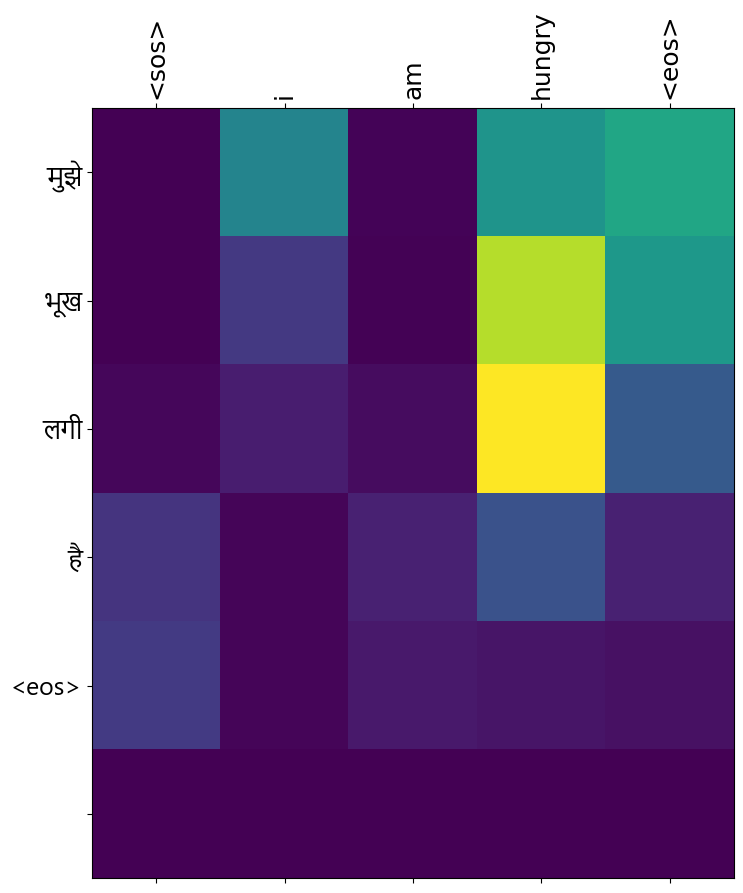

'मुझे भूख लगी है <eos> '

In [61]:
translate("I am hungry", True)

Input: <sos> i am hungry . can you give me something to eat . <eos>
Predicted translation: मुझे क्यों मुझे क्यों लाया हूँ . <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


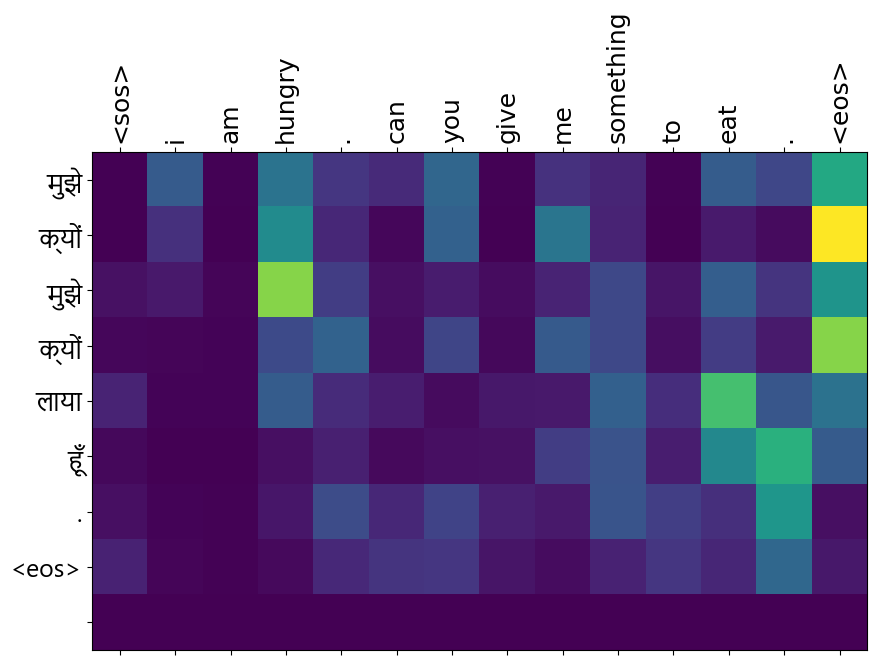

'मुझे क्यों मुझे क्यों लाया हूँ . <eos> '

In [62]:
translate("I am hungry. Can you give me something to eat.", True)

In [63]:
test_input_sentences = []
test_output_sentences = []

for line in open(r'test.en', encoding="utf-8"):

    test_input_sentence = line.rstrip().strip("\n").strip('-')
    test_input_sentences.append(test_input_sentence)


for line in open(r'test.hi'):
    test_output_sentence =  line.rstrip().strip("\n").strip('-')
    line = indic_tokenize.trivial_tokenize(test_output_sentence)
    
    test_output_sentences.append(['<sos>'] + line + ['<eos>'])
    
print(type(test_input_sentences[90]))
print(len(test_output_sentences))
print(test_input_sentences[90])
print(test_output_sentences[90])

<class 'str'>
1000
You're slower than molasses in January.
['<sos>', 'आप', 'जनवरी', 'में', 'गुड़', 'की', 'तुलना', 'में', 'धीमी', 'है', '.', '<eos>']


In [64]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()
evaluate_n_sentences = 10

references = []
candidates = []
for i in range(evaluate_n_sentences):
  try:
    res = translate(test_input_sentences[i], False) 
    ref = test_output_sentences[i].copy()
    ref = [e for e in ref if e not in ('<eos>', '<sos>', '.')]
    references.append(ref)
    listToStr = ' '.join(map(str, test_output_sentences[i]))
    print('Reference Translation: %s' % (listToStr))
    candidate = indic_tokenize.trivial_tokenize(res)
    candidate = [e for e in candidate if e not in ('<', 'eos','>', '.')]
    candidates.append(candidate)
  except:
    print('Sentence :', i+1, ' not translatable ..moving to next' )
score1 = corpus_bleu(references, candidates, smoothing_function=chencherry.method4)
score2 = corpus_bleu(references, candidates)
print('BLEU score on test data without smoothing function: ' ,score2)
print('BLEU score on test data with smoothing function: ' ,score1)

Sentence : 1  not translatable ..moving to next
Input: <sos> storm will be the closest man to him . <eos>
Predicted translation: तूफान के लिए खड़े हो जाएगा . <eos> 
Reference Translation: <sos> तूफान उसे निकटतम आदमी हो जाएगा . <eos>
Input: <sos> well , ilse , now you have to eat something , too . <eos>
Predicted translation: खैर , अभी भी , आप अभी खाने के लिए है . <eos> 
Reference Translation: <sos> खैर , इल्से , अब तुम्हें भी कुछ खाना है . <eos>
Sentence : 4  not translatable ..moving to next
Input: <sos> your smile is saying it loudly , my dear . . . <eos>
Predicted translation: तुम्हारी मुस्कान को वास्तव में है , my dear . <eos> 
Reference Translation: <sos> Your smile is saying it loudly , my dear . . . <eos>
Input: <sos> hey , remember my games of hangman ? <eos>
Predicted translation: यह याद रखो मेरे बारे में ? <eos> 
Reference Translation: <sos> अरे , जल्लाद का मेरे खेल याद है ? <eos>
Input: <sos> no , i just work here in sales . <eos>
Predicted translation: नहीं , मैं सिर्फ इतना

# **Attention : Prediction using Beam Search**

We extend the Decoder Prediction Model to use the Beam Search algorithm with a configurable value of the Beam Width (k)

In [65]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def reduce_mul(l):
    out = 1.0
    for x in l:
        out *= x
    return out

def check_all_done(seqs):
    for seq in seqs:
        if (targ_lang.index_word[seq[-1][0]]!='<eos>') :
            return False
    return True

#seq: [[word,word],[word,word],[word,word]]
#output: [[word,word,word],[word,word,word],[word,word,word]]
def beam_search_step(dec_hid, enc_out, top_seqs, k):       
    all_seqs = []
    scores=[]
    for seq in top_seqs:
        seq_score = reduce_mul([_score for _,_score in seq])
        if (targ_lang.index_word[seq[-1][0]]=='<eos>') :
            all_seqs.append((seq, seq_score, True))
            # Reached on end of string for this seq. Dont predict any further
            continue
        #get predictions using encoder_context & seq last element
        dec_input = tf.expand_dims([seq[-1][0]], 0)
        predictions, dec_hid, _ = decoder(dec_input, dec_hid, enc_out)
        output_step = [(idx,prob) for idx,prob in enumerate(softmax(predictions[0].numpy()))]        
        output_step = sorted(output_step, key=lambda x: x[1], reverse=True)
        for i,word in enumerate(output_step):   
            if i >= k:
                break
            word_index = word[0]
            word_score = word[1]   
            score = seq_score * word_score
            rs_seq = seq + [word]
            done = (word_index == targ_lang.word_index['<eos>'])            
            all_seqs.append((rs_seq, score, done))    
    all_seqs = sorted(all_seqs, key = lambda seq: seq[1], reverse=True)
    topk_seqs = [seq for seq,_,_ in all_seqs[:k]]
    topk_scores = [scores for _,scores,_ in all_seqs[:k]]
    all_done = check_all_done(topk_seqs)
    return topk_seqs, all_done, dec_hid, topk_scores

def evaluate_beam_search(sentence):

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  beam_seqs = [[(targ_lang.word_index['<sos>'],1.0)]]
  beam_size = 3
  for _ in range(max_length_targ):
    beam_seqs, all_done, dec_hidden, scores_seq = beam_search_step(dec_hidden, enc_out, beam_seqs, beam_size)
    if all_done:            
      break 
  # Return the top results
  result=[]
  for top_beam in beam_seqs:
    kresult =''
    for pred_id,_ in top_beam:
      kresult += targ_lang.index_word[pred_id] + ' '
    result= result+[kresult]
  return result, scores_seq

### Using Beam Search

In [66]:
def translate_beam(sentence):
  result, score = evaluate_beam_search(sentence)
  return result, score

In [67]:
translate_beam("I am hungry.")

(['<sos> मुझे बहुत भूख लगी है । <eos> ',
  '<sos> मुझे बहुत भूख लगी है . <eos> ',
  '<sos> मुझे बहुत शर्म की बात है कि बहुत . <eos> '],
 [0.1556345602764303, 0.1414844266958321, 0.01048056875779209])

# *References*

1. The dataset is obtained from [here](http://lotus.kuee.kyoto-u.ac.jp/WAT/indic-multilingual/) 

2. Refer the tensorflow tutorials available on NMT [here](https://tensorflow.org/tutorials/text/nmt_with_attention) and [here](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt) for examples on which this notebook is modelled. 

3. Refer reference code and documentation available [here](https://github.com/prashanthi-r/Eng-Hin-Neural-Machine-Translation) which has been adopted

4. Indic Library documentation can be found [here](https://github.com/anoopkunchukuttan/indic_nlp_library/blob/master/docs/indicnlp.pdf)

5. Toy example for Beam Search adopted provided [here](https://gist.github.com/xylcbd/0abee09de5ca6a0364c4de2aa46ef90f)








# END